# Single-phase flow

In this tutorial we investigate how to solve single-phase flow in PorePy. <br>
We consider
* two-point flux approximation
* multi-point flux approximation
* dual virtual element method

**Note**: This tutorial will focus on a 2d domain, however most of the code works for 1d, 2d, and 3d domains. The case of a 2d domain with an immersed 1d fracture is treated below. <br>

## Problem statement

Let $\Omega$ be a regular domain with boundary $\partial \Omega$. The boundary can be divided in two non-overlapping parts useful to impose Dirichlet ($\partial \Omega_d$) and Neumann ($\partial \Omega_n$) boundary conditions. We indicate with $\mathbf{n}$ the outward unit normal vector of $\partial \Omega$.<br>
The single-phase flow can be written in
* dual formulation as:
$$\nabla \cdot \mathbf{u} = f \qquad \mathbf{u} = - K \nabla p$$
with boundary conditions on $\partial \Omega_d$ and $\partial \Omega_n$:
$$ p = p_b \qquad \mathbf{u} \cdot \mathbf{n} = u_b$$
* primal formulation as:
$$ - \nabla \cdot K \nabla p = f $$
with boundary conditions on $\partial \Omega_d$ and $\partial \Omega_n$:
$$ p = p_b \qquad - K \nabla p \cdot \mathbf{n} = u_b$$

Where $f$ is a scalar source/sink term, $K$ is the permeability matrix, $p_b$ is the pressure at the boundary (Dirichlet condition), and $u_b$ is the flux at the boundary (Neumann condition).<br>

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem. <br><br>

For the example we assume: $\Omega$ as presented below, $\partial \Omega_d = \partial \Omega$, $\partial \Omega_n = \emptyset$, with data: $f = 1$, $K = I$ and $p_b = 0$.

## Import basic modules

Before creating the grid we import NumPy, the SciPy sparse library and PorePy.

In [1]:
import numpy as np
import scipy.sparse as sps
import porepy as pp

## Creation of the grid

We specify number of cells in each dimension and the physical size of the domain. Then we create a Cartesian grid and compute geometric properties such as face centers, cell volumes etc.

In [2]:
Nx = Ny = 20
phys_dims = [1,1]
g = pp.CartGrid([Nx, Ny], phys_dims)
g.compute_geometry()

We plot the grid using the interface with matplotlib.

c:\users\ivar\onedrive - university of bergen\documents\github\porepy\src\porepy\viz\plot_grid.py:197: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_zlim3d(z)


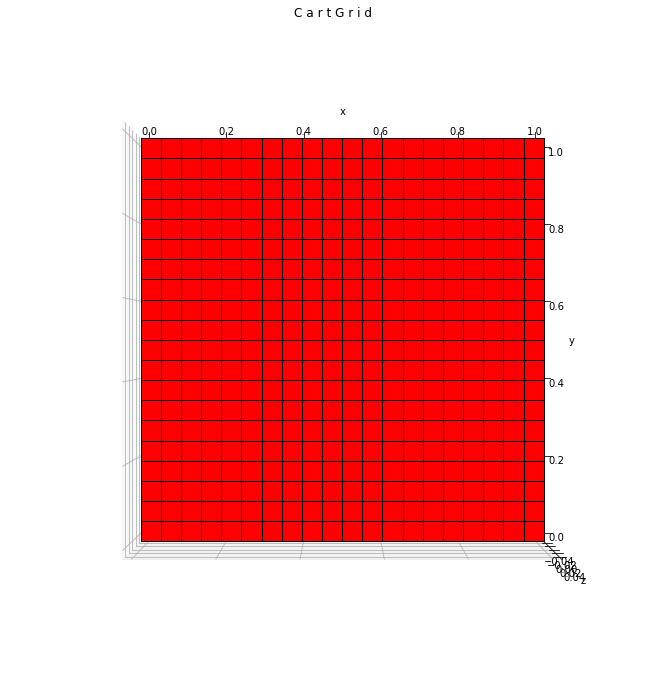

In [3]:
pp.plot_grid(g, figsize=(15, 12))

# Define the problem data

We declare the permeability matrix $K$, the scalar source term $f$, and the boundary conditions

In [4]:
# Permeability
perm = pp.SecondOrderTensor(np.ones(g.num_cells))                     

# Unitary scalar source already integrated in each cell
f = g.cell_volumes

# Boundary conditions
b_faces = g.tags['domain_boundary_faces'].nonzero()[0]
bc = pp.BoundaryCondition(g, b_faces, ['dir']*b_faces.size)
bc_val = np.zeros(g.num_faces)

# Collect all parameters in a dictionary
parameters = {"second_order_tensor": perm, "source": f, "bc": bc, "bc_values": bc_val}

Once all the data are created we group them in a dictionary, where the keyword `"flow"` represent the physical process considered and ensures that the discretization objects use the correct parameters. Note that the call to initialize_default_data assignes default values to the flow parameters which are not specified. This means that we could have omitted the specification of `"bc_values"` and `"second_order_tensor"`, since we have assigned the default values for these.

In [5]:
data_key = "flow"
data = pp.initialize_default_data(g, {}, data_key, parameters)

## Problem solution

In this section we present all the approaches to solve the problem.<br>
**Note**: The problem data are not stored in the solver class.

### Two-point flux approximation

The two-point flux approximation solves the single-phase flow problem in the primal formulation. We use this to discretize the flux term, before assembling it. The source term is discretized using the FV Integral class. The pressure is directly computed.

In [6]:
flow_discretization = pp.Tpfa(data_key)
flow_discretization.discretize(g, data)
A, b_flow = flow_discretization.assemble_matrix_rhs(g, data)

rhs_discretization = pp.ScalarSource(data_key)
rhs_discretization.discretize(g, data)
_, b_rhs = rhs_discretization.assemble_matrix_rhs(g, data)

p_tpfa = sps.linalg.spsolve(A, b_flow+b_rhs) 

To represent the solution.

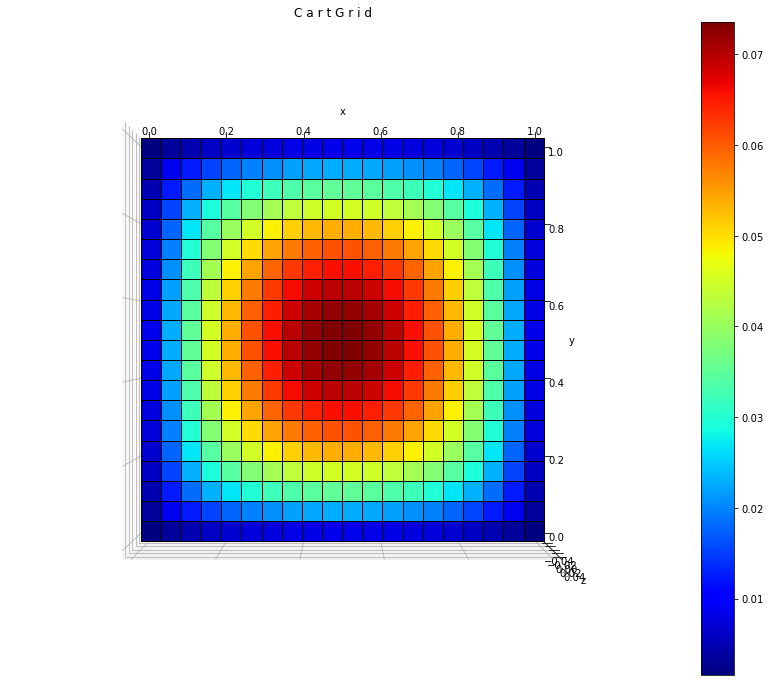

In [7]:
pp.plot_grid(g, p_tpfa, figsize=(15, 12))

Consistency check:

In [8]:
assert np.isclose(np.sum(p_tpfa), 14.192684340967551)

### Multi-point flux approximation 

The multi-point flux approximation solves the single-phase flow problem in the primal formulation. We discretize the flux term anew with the MPFA, and assemble the matrix. Note that the call to Mpfa.discretize() will override the already stored discretization matrix for Tpfa. We reuse the source term discretization, as this is the same for TPFA and MPFA.

In [9]:
flow_discretization = pp.Mpfa(data_key)
flow_discretization.discretize(g, data)
A, b_flow = flow_discretization.assemble_matrix_rhs(g, data)

p_mpfa = sps.linalg.spsolve(A, b_flow+b_rhs)

To represent the solution:

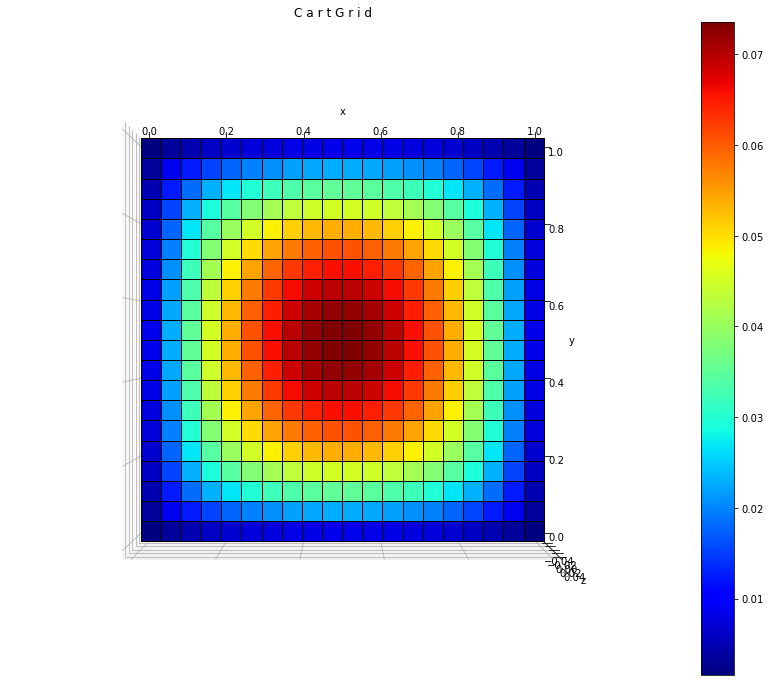

In [10]:
pp.plot_grid(g, p_mpfa, figsize=(15, 12))

Consistency check:

In [11]:
assert np.isclose(np.sum(p_mpfa), 14.192684340967542)

### Dual virtual element method

The dual virtual element method solves the single-phase flow problem in the dual formulation. The pressure and the normal flux to each face are directly computed.

In [12]:
flow_discretization = pp.MVEM("flow")
flow_discretization.discretize(g, data)
A, b_flow = flow_discretization.assemble_matrix_rhs(g, data)

rhs_discretization = pp.DualScalarSource("flow")

data[pp.PARAMETERS]["flow"]["source"] = data[pp.PARAMETERS]["flow"]["source"]
rhs_discretization.discretize(g, data)
_, b_rhs = rhs_discretization.assemble_matrix_rhs(g, data)

up = sps.linalg.spsolve(A, b_flow+b_rhs)                                              

# Extract the normal flux and pressure from the solution
u_mvem = flow_discretization.extract_flux(g, up, data)
p_mvem = flow_discretization.extract_pressure(g, up, data) 

# For visualisation purpose project the flux on a vector piecewise constant field
P0u = flow_discretization.project_flux(g, u_mvem, data)

To represent the pressure and velocity solution:

In [28]:
pp.plot_grid(g, p_mvem, P0u * 0.2, figsize=(15, 12))

(400,) [[-0.05512651 -0.03609096 -0.02565696 ...  0.02565696  0.03609096
   0.05512651]
 [-0.05512651 -0.12248622 -0.17368568 ...  0.17368568  0.12248622
   0.05512651]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] Cartesian grid in 2 dimensions.
Number of cells 400
Number of faces 840
Number of nodes 441



AttributeError: '_Arrow3D' object has no attribute 'do_3d_projection'

AttributeError: '_Arrow3D' object has no attribute 'do_3d_projection'

<Figure size 1080x864 with 2 Axes>

Consistency check:

In [19]:
assert np.isclose(np.sum(p_mvem), 14.348068220560325)
assert np.isclose(np.sum(u_mvem), 0)
assert np.isclose(np.sum(P0u), 0)

# Fractures
We now demonstrate how single-phase flow may be simulated for a domain containing a fracture. The process is very similar to the single-dimensional case. Since the fracture is treated as a lower-dimensional subdomain, we make a separate grid representing it, in addition to the matrix grid. There is also an interface grid connecting the two subdomains. The grids are collected in a mixed-dimensional grid (mdg), and assignment of parameters is handled by looping over subdomain (sd) and interface (intf) grids in the mdg. 

In [20]:
mdg, _ = pp.grid_buckets_2d.single_horizontal([Nx, Ny], x_endpoints=[0.2, 0.8], simplex=False)

We choose slightly different parameters from the case above in order to see the impact of the fracture, to which we assign very low permeability. We also have to assign the normal diffusivity parameter on the interface between the matrix and the fracture.

In [22]:
# Thickness of fracture
aperture = 1e-3
fracture_perm = 1e-5

for sd, data in mdg.subdomains(return_data=True):
    # The concept of specific volumes accounts for the thickness
    # of the fracture, which is collapsed in the mixed-dimensional
    # model.
    specific_volumes = np.power(aperture, mdg.dim_max()-sd.dim)
    # Permeability
    k = np.ones(sd.num_cells) * specific_volumes
    if sd.dim < mdg.dim_max():
        k *= fracture_perm
    perm = pp.SecondOrderTensor(k)                     

    # Unitary scalar source already integrated in each cell
    f = 1e-2* sd.cell_volumes * specific_volumes 

    # Boundary conditions
    b_faces = sd.tags['domain_boundary_faces'].nonzero()[0]
    bc = pp.BoundaryCondition(sd, b_faces, ['dir']*b_faces.size)
    bc_val = np.zeros(sd.num_faces)
    bc_val[b_faces] = sd.face_centers[1, b_faces]

    parameters = {"second_order_tensor": perm, "source": f, "bc": bc, "bc_values": bc_val}
    pp.initialize_data(sd, data, data_key, parameters)

for intf, data in mdg.interfaces(return_data=True):
        _, sd_secondary = mdg.interface_to_subdomain_pair(intf)
        
        # Division through aperture/2 may be thought of as taking the gradient, i.e.
        # dividing by the distance from the matrix to the center of the fracture.
        kn = fracture_perm / (aperture/2)
        pp.initialize_data(intf, data, data_key, {"normal_diffusivity": kn})

Now, we declare the primary variables and assign the discretization for the diffusive and source term for all grids, and for the coupling law on the edge.

In [23]:
flow_discretization = pp.Tpfa(data_key)
source_discretization = pp.ScalarSource(data_key)
for sd, data in mdg.subdomains(return_data=True):
        data[pp.PRIMARY_VARIABLES] = {"pressure": {"cells": 1}}
        data[pp.DISCRETIZATION] = {"pressure": {"diffusive": flow_discretization,
                                                 "source": source_discretization}}
        
flow_coupling_discretization = pp.RobinCoupling(data_key, flow_discretization)        
for intf, data in mdg.interfaces(return_data=True):
    sd_primary, sd_secondary = mdg.interface_to_subdomain_pair(intf)
    data[pp.PRIMARY_VARIABLES] = {"mortar_flux": {"cells": 1}}
    data[pp.COUPLING_DISCRETIZATION] = {
        "lambda": {
            sd_primary: ("pressure", "diffusive"),
            sd_secondary: ("pressure", "diffusive"),
            intf: ("mortar_flux", flow_coupling_discretization),
        }
    }


The assembler takes care of discretization and assembly of the matrices. Note that `solution` vector contains all primary variables: the pressure in both matrix and fracture, as well as the fluxes between the two grids. The ordering is also handled by the assembler.

In [24]:
assembler = pp.Assembler(mdg)
assembler.discretize()
A, b = assembler.assemble_matrix_rhs()
solution = sps.linalg.spsolve(A, b)
assembler.distribute_variable(solution)

Finally, we plot the solution and perform a consistency check.

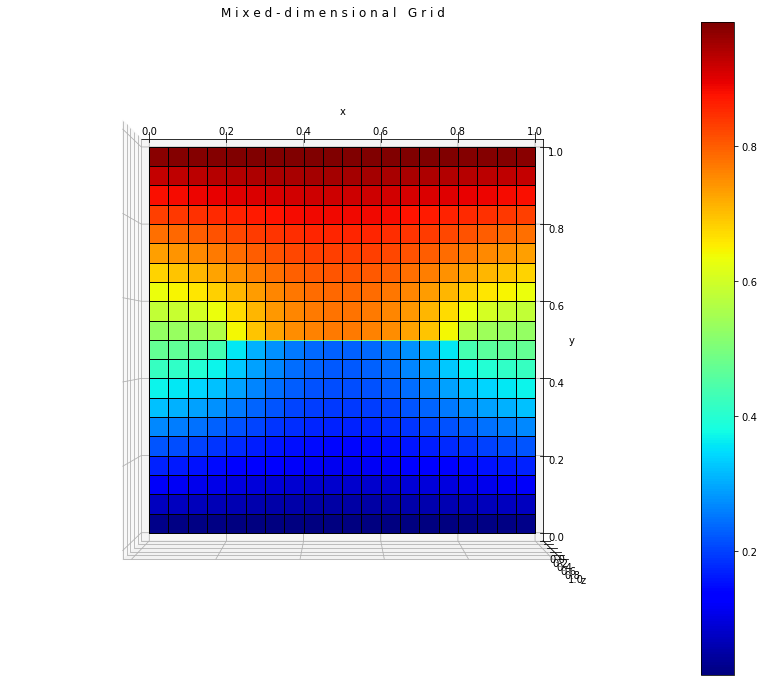

In [25]:
pp.plot_grid(mdg, "pressure",figsize=(15, 12))

In [26]:
sd_2d = list(mdg.subdomains(dim=2))[0]
data_2d = mdg.subdomain_data(sd_2d)
p_2d = data_2d[pp.STATE]["pressure"]
assert np.isclose(np.sum(p_2d), 200.14208519866756)